In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from imblearn.over_sampling import SMOTE  # imblearn library can be installed in Visual Studio by going into Python Environment -> Install new package -> imblearn package
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objs as go
import plotly .offline as offline
import plotly.figure_factory as ff

In [2]:
# Importing dataset and examining it
dataset = pd.read_csv("Beverage.csv")
print(dataset.head())
print(dataset.shape)
print(dataset.info())
print(dataset.describe())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol quality  
0      8.8  Normal  
1      9.5  Normal  
2     10.1  Normal  
3 

In [3]:
# Converting Categorical features into Numerical features
dataset['quality'] = dataset['quality'].map({'Poor':0, 'Normal':1, 'Excellent': 1})

# Plotting Correlation Heatmap
corrs = dataset.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.plot(figure,filename='corrheatmap.html')

'corrheatmap.html'

In [4]:
# Dividing dataset into label and feature sets
X = dataset.drop(['quality', 'density'], axis = 1) # Features
Y = dataset['quality'] # Labels
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(4898, 10)
(4898,)


In [5]:
# Normalizing numerical features so that each feature has mean 0 and variance 1
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

# Dividing dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split( X_scaled, Y, test_size = 0.3, random_state = 100)

print(X_train.shape)
print(X_test.shape)

(3428, 10)
(1470, 10)


In [6]:
# Implementing Oversampling to balance the dataset; SMOTE stands for Synthetic Minority Oversampling TEchnique
print("Number of observations in each class before oversampling (training data): \n", pd.Series(Y_train).value_counts())

smote = SMOTE(random_state = 101)
X_train,Y_train = smote.fit_sample(X_train,Y_train)

print("Number of observations in each class after oversampling (training data): \n", pd.Series(Y_train).value_counts())

Number of observations in each class before oversampling (training data): 
 1    3297
0     131
Name: quality, dtype: int64
Number of observations in each class after oversampling (training data): 
 1    3297
0    3297
Name: quality, dtype: int64


In [7]:
# Tuning the random forest parameter 'n_estimators' and implementing cross-validation using Grid Search
rfc = RandomForestClassifier(criterion='entropy', max_features='auto', random_state=1)
grid_param = {'n_estimators': [50, 100, 150, 200, 250, 300]}

gd_sr = GridSearchCV(estimator=rfc, param_grid=grid_param, scoring='recall', cv=5)
gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

{'n_estimators': 100}
0.9663305283487379


free sulfur dioxide     0.196320
volatile acidity        0.147076
alcohol                 0.100641
total sulfur dioxide    0.090601
fixed acidity           0.086640
chlorides               0.083131
residual sugar          0.079286
citric acid             0.079200
sulphates               0.070684
pH                      0.066421
dtype: float64


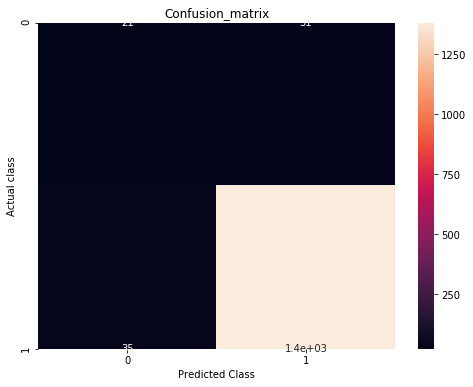

Confusion matrix: 
 [[  21   31]
 [  35 1383]]
TP:  1383
TN:  21
FP:  31
FN:  35


In [8]:
# Building random forest using the tuned parameter
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X_train,Y_train)
featimp = pd.Series(rfc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = rfc.predict(X_test)
conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

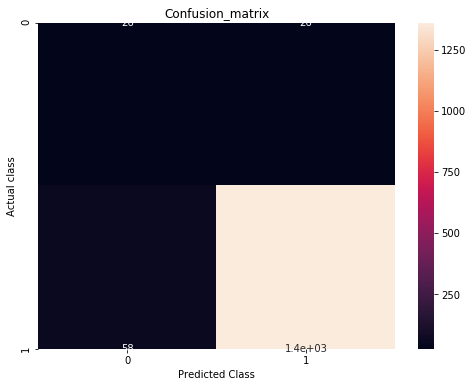

Confusion matrix: 
 [[  26   26]
 [  58 1360]]
TP:  1360
TN:  26
FP:  26
FN:  58


In [9]:
# Selecting features with higher sifnificance and redefining feature set
X = dataset[['free sulfur dioxide', 'volatile acidity', 'alcohol', 'total sulfur dioxide', 'fixed acidity']]

feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

# Dividing dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split( X_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X_train,Y_train = smote.fit_sample(X_train,Y_train)

rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X_train,Y_train)

Y_pred = rfc.predict(X_test)
conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

Variance explained by each of the n_components:  [0.38067246 0.20994741]
Total variance explained by the n_components:  0.5906198675490663


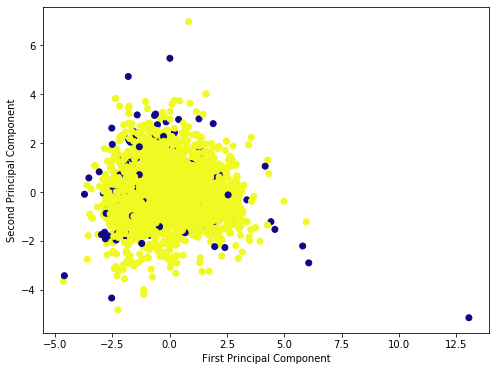

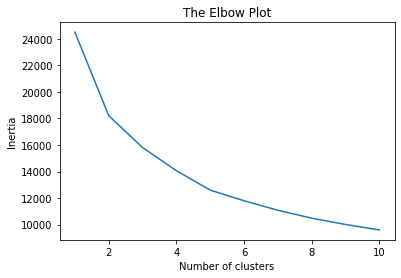

In [10]:
# Implementing PCA to visualize dataset
pca = PCA(n_components = 2)
pca.fit(X_scaled)
x_pca = pca.transform(X_scaled)
print("Variance explained by each of the n_components: ",pca.explained_variance_ratio_)
print("Total variance explained by the n_components: ",sum(pca.explained_variance_ratio_))

plt.figure(figsize = (8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=Y, cmap='plasma')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Finding the number of clusters (K) - Elbow Plot Method
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 100)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('The Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Cluster Centers: 
 [[-0.54732828  0.02114965  0.53688255 -0.64762398 -0.07434897]
 [ 0.69321494 -0.02678695 -0.67998498  0.82024379  0.09416618]]


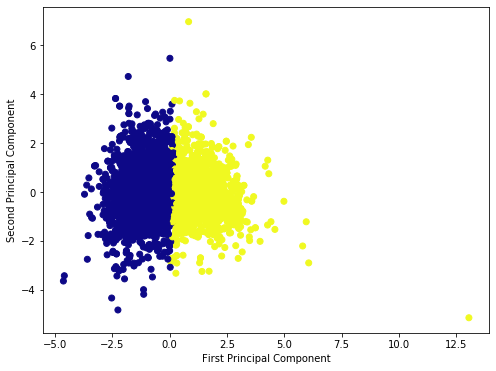

In [11]:
# If K=2
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_scaled)
print("Cluster Centers: \n",kmeans.cluster_centers_)
plt.figure(figsize = (8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=kmeans.labels_, cmap='plasma')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()